In [6]:
from __future__ import absolute_import, division, print_function, unicode_literals
%matplotlib notebook
import pandas as pd
import mygrad as mg
import numpy as np
import re
from mynn.layers.dense import dense
from mynn.initializers.glorot_normal import glorot_normal
from mynn.optimizers.adam import Adam
from mygrad.nnet.losses import softmax_crossentropy
from gensim.models.keyedvectors import KeyedVectors
from noggin import create_plot

In [7]:
glove = KeyedVectors.load_word2vec_format("glove.6B.50d.txt.w2v", binary=False)

In [8]:
"""
Running this file trains an argument quality model and saves it to a file ArgumentQualityModel.npy.
Do not run this every time you want to test the model on your data.
Only run this once at the beginning to create the ArgumentQuality.npy file
    or to retrain the model.
This file should take a few minutes to run as it trains over 10 epochs on thousands of data items.
"""

# Loads glove, which contains english words and their embeddings into 50-dimensional vectors



def l2loss(pred, actual):  # L2 loss function (mean square distance)
    """

    Parameters
    ----------
    pred: Union[mygrad.Tensor, numpy.ndarray]
        A tensor or numpy array containing the model's predicted values
    actual: Union[mygrad.Tensor, numpy.ndarray]
        A tensor or numpy array containing the actual values

    Returns
    -------
    mg.Tensor
        A tensor containing the mean square distance between the prediction and actual values.
    """
    return mg.mean(mg.square(pred - actual))
class RNN:  # The RNN class, which passes the data through a gated recurrent unit to convert each sentence into an array
    def __init__(self, dim_input, dim_recurrent, dim_output):
        """ Initializes all layers needed for RNN

        Parameters
        ----------
        dim_input: int
            Dimensionality of data passed to RNN (C)

        dim_recurrent: int
            Dimensionality of hidden state in RNN (D)

        dim_output: int
            Dimensionality of output of RNN (K)
        """
        
        self.fc_h2y = dense(dim_recurrent, dim_output, weight_initializer=glorot_normal)
        self.Uz = mg.Tensor(
            np.random.randn(dim_input * dim_recurrent).reshape(dim_input, dim_recurrent)
        )
        self.Wz = mg.Tensor(
            np.random.randn(dim_recurrent * dim_recurrent).reshape(
                dim_recurrent, dim_recurrent
            )
        )
        self.bz = mg.Tensor(np.random.randn(dim_recurrent))
        self.Ur = mg.Tensor(
            np.random.randn(dim_input * dim_recurrent).reshape(dim_input, dim_recurrent)
        )
        self.Wr = mg.Tensor(
            np.random.randn(dim_recurrent * dim_recurrent).reshape(
                dim_recurrent, dim_recurrent
            )
        )
        self.br = mg.Tensor(np.random.randn(dim_recurrent))
        self.Uh = mg.Tensor(
            np.random.randn(dim_input * dim_recurrent).reshape(dim_input, dim_recurrent)
        )
        self.Wh = mg.Tensor(
            np.random.randn(dim_recurrent * dim_recurrent).reshape(
                dim_recurrent, dim_recurrent
            )
        )
        self.bh = mg.Tensor(np.random.randn(dim_recurrent))

    def __call__(self, x):
        """ Performs the full forward pass for the RNN.

        Note that we only care about the last y - the final classification scores for the full sequence

        Parameters
        ----------
        x: Union[numpy.ndarray, mygrad.Tensor], shape=(T, C)
            The one-hot encodings for the sequence

        Returns
        -------
        mygrad.Tensor, shape=(1, K)
            The final classification of the sequence
        """

        h = mg.nnet.gru(
            x,
            self.Uz,
            self.Wz,
            self.bz,
            self.Ur,
            self.Wr,
            self.br,
            self.Uh,
            self.Wh,
            self.bh,
        )
        return self.fc_h2y(h[-1])

    @property
    def parameters(self):
        """ A convenience function for getting all the parameters of our model.

        This can be accessed as an attribute, via `model.parameters`

        Returns
        -------
        Tuple[Tensor, ...]
            A tuple containing all of the learnable parameters for our model
        """
        return self.fc_h2y.parameters + (self.Uz, self.Wz, self.bz, self.Ur, self.Wr, self.br, self.Uh, self.Wh, self.bh)

In [14]:
x_dates = []
y_dates = []

In [9]:
"""
File Reading
"""
a = []
for i in range(32):
    try:
        for j in range(100):
            with open("../TrainingData/TeslaTrainingData_2019-10-"+str(i)+"/Tesla"+str(j)+".txt", mode='rb') as file:
                try:
                    a.append(str(file.read()))
                except Exception as e:
                    print(e)
                    print(file.name)
    except:
        print("10/"+str(i))
for i in range(32):
    if i != 10:
        try:
            for j in range(100):
                with open("../TrainingData/TeslaTrainingData_2019-11-"+str(i)+"/Tesla"+str(j)+".txt", mode='rb') as file:
                    try:
                        a.append(str(file.read()))
                    except Exception as e:
                        print(file.name)
        except:
            print("11/"+str(i))
            
for i in range(32):
    if i != 10:
        try:
            for j in range(100):
                with open("../TrainingData/TeslaTrainingData_2019-12-"+str(i)+"/Tesla"+str(j)+".txt", mode='rb') as file:
                    try:
                        a.append(str(file.read()))
                    except Exception as e:
                        print(file.name)
        except:
            print("11/"+str(i))
print(len(a))

10/0
10/1
10/2
10/3
10/4
10/5
10/6
10/7
10/8
10/9
10/10
10/11
10/12
10/13
10/19
10/20
10/26
10/27
11/0
11/2
11/3
11/9
11/16
11/17
11/22
11/23
11/24
11/30
11/31
11/0
11/1
11/7
11/8
11/14
11/15
11/17
11/18
11/19
11/20
11/21
11/22
11/23
11/24
11/25
11/26
11/27
11/28
11/29
11/30
11/31
4400


In [10]:
x_train = np.array(a)

In [11]:
"""
Formats data labels
"""
def toFinal(a):
    for i in range(len(a)):
        if a[i] > 0:
            a[i] = 1
        else:
            a[i] = 0

In [13]:
"""
Reads and formats data labels
"""
y_train = []
for i in range(32):
    try:
        with open("../TrainingData/TeslaTrainingData_2019-10-"+str(i)+"/Tesla.csv") as file:
            j = file.read().split(',')[1]
            assert j is not None
            j = j.replace('\n','')
            for _ in range(100):
                y_train.append(float(j))
    except:
        print("Bad: 10/"+str(i))
for i in range(32):
    try:
        with open("../TrainingData/TeslaTrainingData_2019-11-"+str(i)+"/Tesla.csv") as file:
            j = file.read().split(',')[1]
            assert j is not None
            j = j.replace('\n','')
            for _ in range(100):
                y_train.append(float(j))
    except:
        print("Bad: 11/"+str(i))
    
for i in range(32):
    try:
        with open("../TrainingData/TeslaTrainingData_2019-12-"+str(i)+"/Tesla.csv") as file:
            j = file.read().split(',')[1]
            assert j is not None
            j = j.replace('\n','')
            for _ in range(100):
                y_train.append(float(j))
    except:
        print("Bad: 12/"+str(i))
toFinal(y_train)
# print(y_train)
y_train = np.array(y_train)
# print(y_train)

x_test = x_train[3600:]
x_train = x_train[:3600]

print(y_train.shape)
print(x_train.shape)
print(x_test.shape)

Bad: 10/0
Bad: 10/1
Bad: 10/2
Bad: 10/3
Bad: 10/4
Bad: 10/5
Bad: 10/6
Bad: 10/7
Bad: 10/8
Bad: 10/9
Bad: 10/10
Bad: 10/11
Bad: 10/12
Bad: 10/13
Bad: 10/19
Bad: 10/20
Bad: 10/23
Bad: 10/25
Bad: 10/26
Bad: 10/27
Bad: 11/0
Bad: 11/2
Bad: 11/3
Bad: 11/9
Bad: 11/10
Bad: 11/16
Bad: 11/17
Bad: 11/22
Bad: 11/23
Bad: 11/24
Bad: 11/28
Bad: 11/30
Bad: 11/31
Bad: 12/0
Bad: 12/1
Bad: 12/7
Bad: 12/8
Bad: 12/14
Bad: 12/15
Bad: 12/16
Bad: 12/17
Bad: 12/18
Bad: 12/19
Bad: 12/20
Bad: 12/21
Bad: 12/22
Bad: 12/23
Bad: 12/24
Bad: 12/25
Bad: 12/26
Bad: 12/27
Bad: 12/28
Bad: 12/29
Bad: 12/30
Bad: 12/31
(4100,)
(3600,)
(800,)


In [9]:
print(np.count_nonzero(y_train))
print(y_train.size)
y_test = y_train[1200:1500]
y_train = y_train[:1200]
x_test = x_train[1200:1500]
x_train = x_train[:1200]
print(x_test.shape)
print(y_test.shape)

4100


AttributeError: 'list' object has no attribute 'size'

<IPython.core.display.Javascript object>


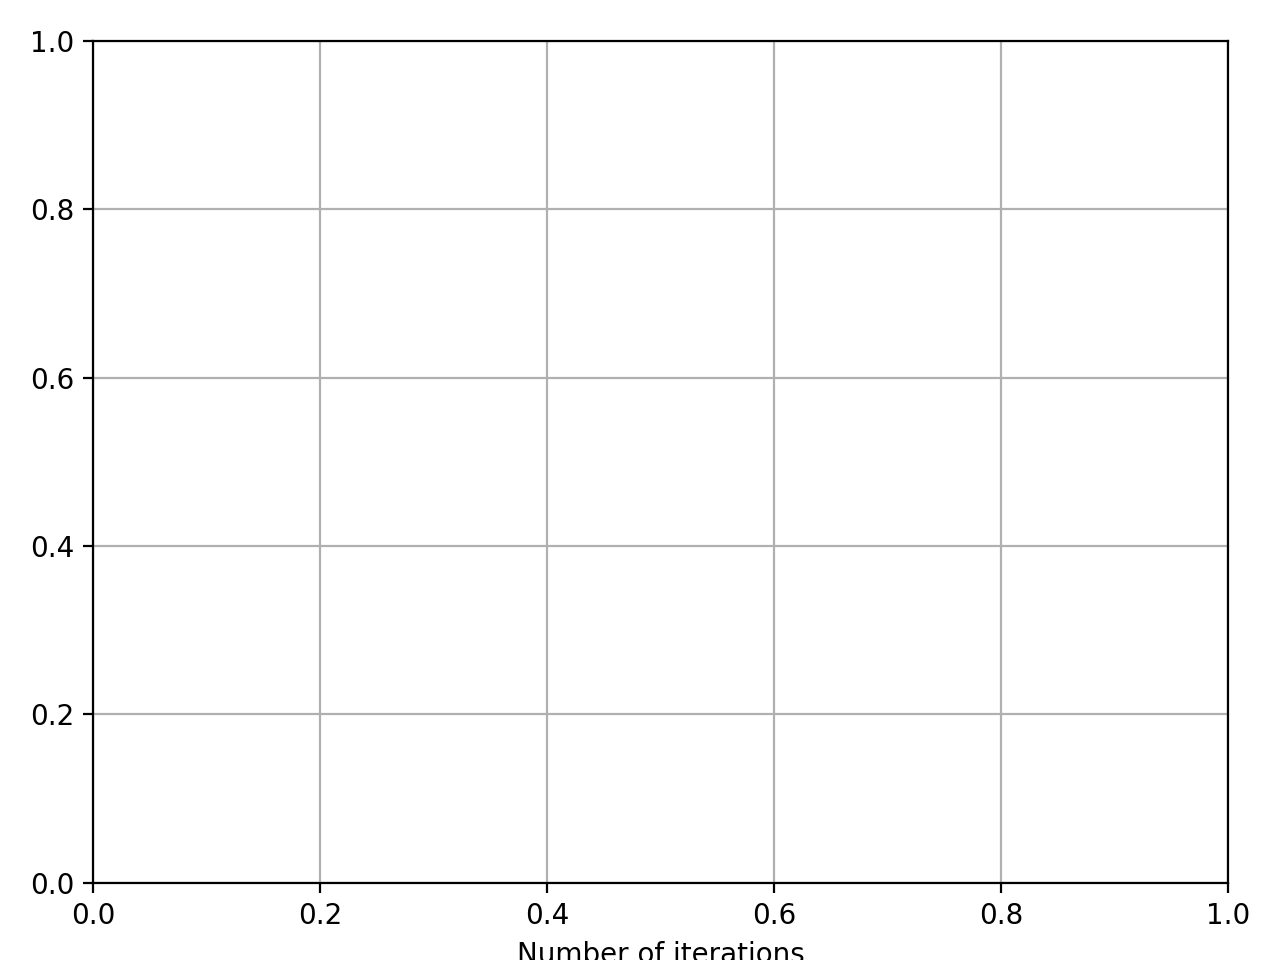

In [10]:
"""
Trains Model
"""
dim_input = 50
dim_recurrent = 20
dim_output = 2
plotter, fig, ax = create_plot(metrics=["loss"])
rnn = RNN(dim_input, dim_recurrent, dim_output)
optimizer = Adam(rnn.parameters)

In [2]:
batch_size = 20

# Trains the model over 10 epochs.
for epoch_cnt in range(50):
    idxs = np.arange(len(x_train))
    np.random.shuffle(idxs)
    print("training epoch number ", epoch_cnt)

    for batch_cnt in range(0, len(x_train) // batch_size):
        batch_indices = idxs[batch_cnt * batch_size : (batch_cnt + 1) * batch_size]
        
        old = x_train[batch_indices]
        batch = np.ascontiguousarray(np.swapaxes(old, 0, 1))
        prediction = rnn(batch)
        #print(prediction.shape)
        truth = ytrain[batch_indices]
        #print("pred: ", prediction)
        #print("truth: ", truth)
        loss = softmax_crossentropy(prediction, truth)

        loss.backward()

        optimizer.step()
        loss.null_gradients()

NameError: name 'np' is not defined

In [ ]:
print(len(y_test[y_test==0]))
print(len(y_test[y_test==1]))